# LSTM - based sentiment analysis

Importing necessary packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from keras import backend as K
from keras.layers import Input, Embedding, Multiply, Permute, Lambda
from keras.layers import LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from sklearn.model_selection import train_test_split

## 1. Preparing the data

### 1.1 Extracting the data

Loading the dataset from the .csv file

In [4]:
df = pd.read_csv('../data/all_emotions.csv', sep='|')
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,emotion
0,i'm anxious about the possibility of disappoin...,anxious
1,i'm so sick of being used and taken advantage of.,sad
2,i'm proud of my ability to maintain a positive...,proud
3,i am struggling to stay focused and engaged in...,bored
4,i regret not being there for my sibling when t...,regretful


Converting emotions to one-hot encoded numpy array

In [5]:
emotions = pd.get_dummies(df['emotion'])
emotions = np.array(emotions.values)
emotions

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Converting texts into numpy array

In [6]:
texts = np.array(df['text'].values)
texts

array(["i'm anxious about the possibility of disappointing my friends or family.",
       "i'm so sick of being used and taken advantage of.",
       "i'm proud of my ability to maintain a positive attitude in the face of adversity.",
       ..., 'i regret not being more frugal with my money.',
       "i'm afraid that my anxiety is going to destroy my confidence.",
       'you are a total waste of my time.'], dtype=object)

### 1.2 Text vectorization

Defining some constants that will be used for tikenizing the texts

In [7]:
MAX_WORDS = 3000
MAX_TEXT_LEN = 30
FILTERS='–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»'

Creating a Tokenizer instance from Keras and fitting it on our corpus

In [8]:
tokenizer = Tokenizer(num_words=MAX_WORDS, filters=FILTERS, lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(texts)

Vectorizing text data

In [9]:
vectorized_texts = tokenizer.texts_to_sequences(texts)
vectorized_texts = pad_sequences(vectorized_texts, maxlen=MAX_TEXT_LEN)
print(vectorized_texts)

[[  0   0   0 ...  84  41 168]
 [  0   0   0 ...  69 142   4]
 [  0   0   0 ...  76   4 706]
 ...
 [  0   0   0 ...  20   3 375]
 [  0   0   0 ...   6   3 941]
 [  0   0   0 ...   3  68   7]]


### 1.3 Preparing training and testing sets

Splitting the dataset into training (80%) and testing (20%) sets

In [10]:
x_train, x_test, y_train, y_test = train_test_split(vectorized_texts, emotions, test_size=0.3)

In [11]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(84530, 30) (36228, 30)
(84530, 14) (36228, 14)


## 2. Creating and training the model

### 2.1 Building and training the model

Defining the architecture of the model

In [12]:
# model = Sequential()
# model.add(Embedding(MAX_WORDS, 128, input_length = MAX_TEXT_LEN))
#
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
#
# model.add(Bidirectional(LSTM(32, return_sequences=True)))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
#
# model.add(LSTM(16))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
#
# model.add(Dense(14, activation='softmax'))
# model.summary()

In [13]:
def attention(input_tensor):
    # input_tensor.shape = (batch_size, time_steps, input_dim)
    time_steps = input_tensor.shape[1]
    input_dim = input_tensor.shape[2]

    # Compute attention scores
    a = Permute((2, 1))(input_tensor)
    a = Dense(time_steps, activation='sigmoid')(a)
    a = Dense(time_steps, activation='softmax')(a)

    # Apply attention weights
    a = Permute((2, 1))(a)
    a = Multiply()([input_tensor, a])
    a = Lambda(lambda x: K.sum(x, axis=1))(a)
    return a

In [14]:
input_layer = Input(shape=(MAX_TEXT_LEN,))
embedding_layer = Embedding(MAX_WORDS, 128, input_length=MAX_TEXT_LEN)(input_layer)

lstm_layer1 = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
dropout_layer1 = Dropout(0.5)(lstm_layer1)
batchnorm_layer1 = BatchNormalization()(dropout_layer1)

lstm_layer2 = Bidirectional(LSTM(32, return_sequences=True))(batchnorm_layer1)
dropout_layer2 = Dropout(0.5)(lstm_layer2)
batchnorm_layer2 = BatchNormalization()(dropout_layer2)

lstm_layer3 = Bidirectional(LSTM(16, return_sequences=True))(batchnorm_layer2)
dropout_layer3 = Dropout(0.5)(lstm_layer3)
batchnorm_layer3 = BatchNormalization()(dropout_layer3)

# lstm_layer4 = LSTM(4, return_sequences=True)(batchnorm_layer3)
# dropout_layer4 = Dropout(0.5)(lstm_layer4)
# batchnorm_layer4 = BatchNormalization()(dropout_layer4)

# lstm_layer5 = LSTM(4, return_sequences=True)(batchnorm_layer4)
# dropout_layer5 = Dropout(0.5)(lstm_layer5)
# batchnorm_layer5 = BatchNormalization()(dropout_layer5)

# Add attention mechanism
attention_layer = attention(lstm_layer3)

output_layer = Dense(14, activation='sigmoid')(attention_layer)

model = Model(inputs=input_layer, outputs=output_layer)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 128)      384000      ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 30, 128)      98816       ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 30, 128)      0           ['bidirectional[0][0]']          
                                                                                              

Compiling the model

In [16]:
model.compile(loss=['categorical_crossentropy'], metrics=['accuracy'], optimizer=Adam(0.0001))

Training the model

In [18]:
history = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_split=0.3)

Epoch 1/30
1850/1850 [==============================] - 184s 99ms/step - loss: 0.3996 - accuracy: 0.8882 - val_loss: 0.3596 - val_accuracy: 0.8922
Epoch 2/30
1850/1850 [==============================] - 183s 99ms/step - loss: 0.3040 - accuracy: 0.9117 - val_loss: 0.3197 - val_accuracy: 0.9032
Epoch 3/30
1850/1850 [==============================] - 183s 99ms/step - loss: 0.2605 - accuracy: 0.9224 - val_loss: 0.2909 - val_accuracy: 0.9099
Epoch 4/30
1850/1850 [==============================] - 183s 99ms/step - loss: 0.2357 - accuracy: 0.9279 - val_loss: 0.2955 - val_accuracy: 0.9100
Epoch 5/30
1850/1850 [==============================] - 183s 99ms/step - loss: 0.2159 - accuracy: 0.9343 - val_loss: 0.2925 - val_accuracy: 0.9105
Epoch 6/30
1850/1850 [==============================] - 182s 98ms/step - loss: 0.1970 - accuracy: 0.9383 - val_loss: 0.2819 - val_accuracy: 0.9130
Epoch 7/30
1850/1850 [==============================] - 180s 97ms/step - loss: 0.1847 - accuracy: 0.9424 - val_loss: 0

### 2.2 Visualizing model training history

Summarizing history for loss

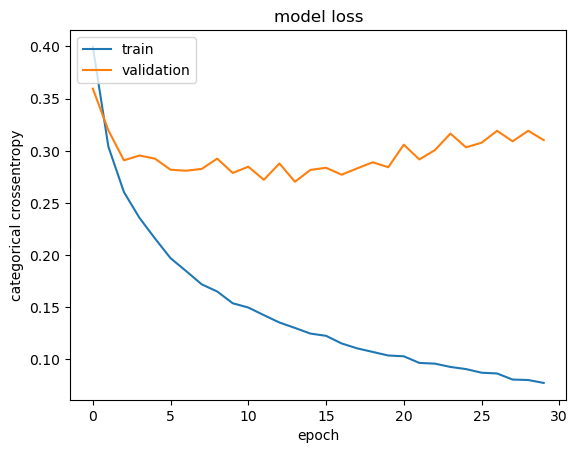

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('categorical crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Summarizing history for accuracy

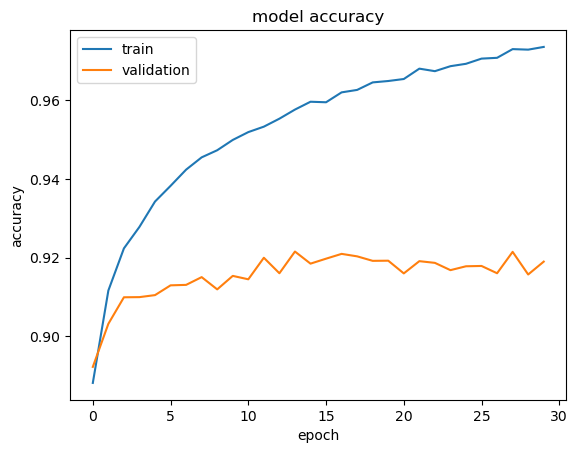

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 2.3 Testing the model

##### Evaluating the model

In [21]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'loss: {loss}')
print(f'accuracy:{accuracy}')

1133/1133 [==============================] - 22s 19ms/step - loss: 0.3262 - accuracy: 0.9164
loss: 0.32620492577552795
accuracy:0.9163630604743958


*The accuracy is about 90%*

##### Testing on examples

Helper function to detokenize the text

In [22]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

def sequence_to_text(list_of_indices):
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

Printing all the unique emotion entries in the dataframe

In [23]:
emotions_list = list(df['emotion'].unique())
emotions_list

['anxious',
 'sad',
 'proud',
 'bored',
 'regretful',
 'happy',
 'angry',
 'grateful',
 'hopeful',
 'guilty',
 'fearful',
 'excited',
 'love',
 'neutral']

In [24]:
examples = {
    'The sun is shining, the birds are singing, and life is full of endless possibilities!': 'happy',
    'The once-bustling streets are now silent and empty, as the world grapples with the devastating effects of a global pandemic.': 'sad',
    'I am infuriated by the blatant disregard for basic human rights and equality that continues to plague our society.': 'angry',
    'The sound of thunder in the distance filled her with fear, as she knew a storm was brewing and she was alone in the house.': 'fearful',
    'As she waited for the exam results to be posted online, her heart raced with anxiety and she couldn\'t stop second-guessing her answers.': 'anxious',
    'I can hardly contain my excitement about the upcoming trip to Europe - the thought of exploring new cities and immersing myself in different cultures fills me with anticipation!': 'excited',
    'Staring at the clock, watching the minutes tick by, he couldn\'t help but feel bored out of his mind in the never-ending meeting.': 'bored',
    'As she looked around the dinner table surrounded by her loved ones, she felt an overwhelming sense of gratitude for the warmth and comfort of their company.': 'grateful',
    'He couldn\'t shake the feeling of guilt as he realized he had forgotten his best friend\'s birthday, despite promising to make it special.': 'guilty',
    'The way that people from all over the world came together to support each other during the pandemic gives me hope that we can overcome any challenge when we stand united.': 'hopeful',
    'Whenever I\'m with you, my heart skips a beat and I can\'t help but feel an overwhelming sense of love and happiness.': 'love',
    'She felt an immense sense of pride as she watched her daughter receive her diploma, knowing that all her hard work and dedication had paid off in such a meaningful way.': 'proud',
    'He looked back on his life with regret, wishing he had taken more risks and pursued his passions instead of always playing it safe.': 'regretful',
    'The cat sat lazily on the windowsill, watching the world go by outside.': 'neutral'
}

In [25]:
correct = 0

for example, emotion in examples.items():
  tokens = tokenizer.texts_to_sequences([example])[0]
  restored_sentence = sequence_to_text(tokens)
  pad_tokens = pad_sequences([tokens], maxlen=MAX_TEXT_LEN)
  prediction = sorted(emotions_list)[np.argmax(model.predict(pad_tokens))]

  if prediction == emotion:
      correct += 1

  print('Input Sentence:')
  print(example)
  print('Restored Sentence:')
  print(restored_sentence)
  print(f'Expected output: {emotion}')
  print(f'Model output: {prediction}')

1/1 [==============================] - 3s 3s/step
Input Sentence:
The sun is shining, the birds are singing, and life is full of endless possibilities!
Restored Sentence:
['the', 'sun', 'is', 'shining', 'the', 'birds', 're', 'singing', 'nd', 'life', 'is', 'full', 'of', 'endless']
Expected output: happy
Model output: hopeful
1/1 [==============================] - 0s 31ms/step
Input Sentence:
The once-bustling streets are now silent and empty, as the world grapples with the devastating effects of a global pandemic.
Restored Sentence:
['the', 'once', 'bustling', 'streets', 're', 'now', 'silent', 'nd', 'e', 'ty', 's', 'the', 'world', 'gr', 'les', 'with', 'the', 'dev', 'st', 'ting', 'of', 'glob', 'l', 'nde', 'ic']
Expected output: sad
Model output: sad
1/1 [==============================] - 0s 31ms/step
Input Sentence:
I am infuriated by the blatant disregard for basic human rights and equality that continues to plague our society.
Restored Sentence:
['i', 'infuri', 'ted', 'by', 'the', 'bl'

In [26]:
print(f'Predicted correctly {correct} / 14')

Predicted correctly 8 / 14


In [269]:
model.save('../models/model_attention')

In [44]:
import tensorflow as tf
new_model = tf.keras.models.load_model('../models/model_attention')

In [45]:
loss, accuracy = new_model.evaluate(x_test, y_test)
print(f'loss: {loss}')
print(f'accuracy:{accuracy}')

1133/1133 [==============================] - 121s 104ms/step - loss: 0.3747 - accuracy: 0.8993
loss: 0.3747382164001465
accuracy:0.8993319869041443
